<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/DL_Task2_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pengembangan Model Deep Learning dengan CNN dan MLP untuk Dataset SVHN menggunakan PyTorch

In [1]:
# Instalasi library yang diperlukan
!pip install -q torch torchvision matplotlib scikit-learn pandas seaborn

# Import library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



# Set random seed untuk reproduktibilitas
np.random.seed(42)
# Set random seed untuk PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00


## 1. Persiapan Dataset SVHN



In [3]:
# Definisi transformasi data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Parameter batch size
batch_size = 128

# Memuat dataset SVHN
trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Nama kelas SVHN (digit 0-9)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Menampilkan informasi dataset
print(f"Jumlah data pelatihan: {len(trainset)}")
print(f"Jumlah data pengujian: {len(testset)}")
print(f"Jumlah kelas: {len(classes)}")
print(f"Kelas: {classes}")
print(f"Ukuran gambar: {trainset[0][0].shape}")

100%|██████████| 182M/182M [00:25<00:00, 7.15MB/s]
100%|██████████| 64.3M/64.3M [00:13<00:00, 4.74MB/s]


Jumlah data pelatihan: 73257
Jumlah data pengujian: 26032
Jumlah kelas: 10
Kelas: ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
Ukuran gambar: torch.Size([3, 32, 32])


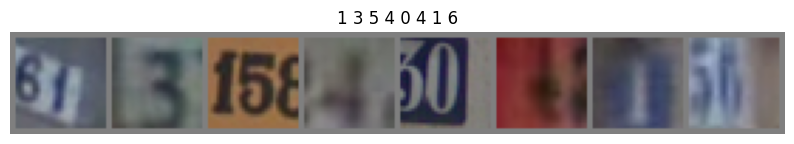

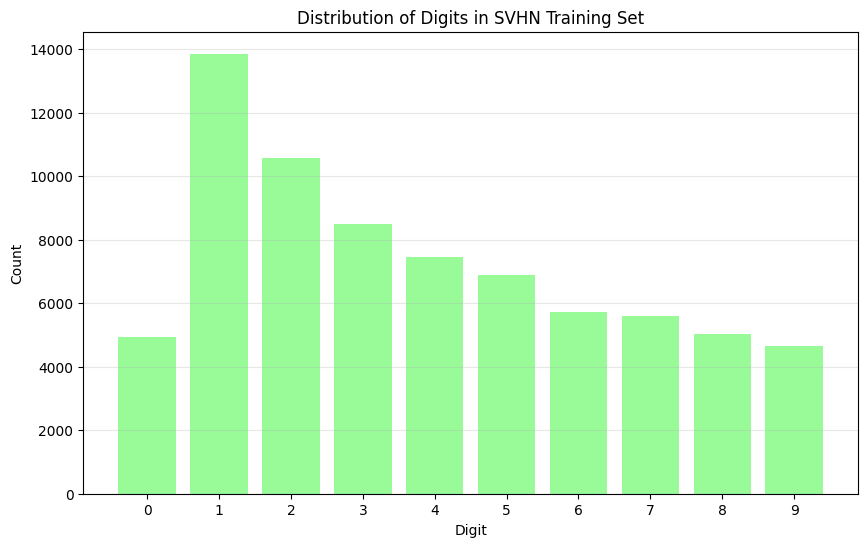

In [22]:
# Visualisasi beberapa gambar dari dataset
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Ambil beberapa gambar secara acak
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Tampilkan gambar
plt.figure(figsize=(10, 4))
imshow(torchvision.utils.make_grid(images[:8]))
plt.title(' '.join(f'{classes[labels[j]]}' for j in range(8)))
plt.show()

# Distribusi label di dataset training
label_counts = {i: 0 for i in range(10)}
for _, label in trainset:
    label_counts[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(range(10), list(label_counts.values()), color='palegreen')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digits in SVHN Training Set')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.3)
plt.show()

## 2. Implementasi Model CNN



In [5]:
# Model CNN untuk SVHN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        # Input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Output: 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: 64x32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: 128x32x32

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Output setelah 3 conv+pool: 128x4x4

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional blocks
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv -> BatchNorm -> ReLU -> MaxPool

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Inisialisasi model CNN
cnn_model = CNN().to(device)
# Tampilkan ringkasan model
print(cnn_model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## 3. Implementasi Model MLP (Multi-Layer Perceptron)




In [6]:
# Model MLP (Vanilla) untuk SVHN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Flatten input 3x32x32 = 3072
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Flatten input
        x = x.view(-1, 3 * 32 * 32)

        # Fully connected layers dengan ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Inisialisasi model MLP
mlp_model = MLP().to(device)
# Tampilkan ringkasan model
print(mlp_model)

MLP(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## Fungsi untuk Pelatihan dan Evaluasi Model



In [7]:
# Fungsi untuk melatih model
def train_model(model, criterion, optimizer, num_epochs=15):
    model.to(device)
    train_losses = []
    train_accs = []

    # Untuk tracking waktu
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistik
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print progress setiap 100 batch
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')

        # Menghitung loss dan accuracy rata-rata untuk epoch ini
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Print epoch stats
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    # Print total training time
    total_time = time.time() - start_time
    print(f'Training selesai dalam {total_time:.2f} detik')

    return train_losses, train_accs

In [8]:
# Fungsi untuk evaluasi model
def evaluate_model(model, testloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    # Untuk tracking waktu
    start_time = time.time()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Mengumpulkan prediksi dan label
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Membuat confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # ROC curve dan AUC (One-vs-Rest)
    # Perlu mengkonversi output ke format one-hot untuk ROC/AUC
    model.eval()
    probs = []
    with torch.no_grad():
        for data in testloader:
            images, _ = data
            images = images.to(device)
            output = model(images)
            probs.append(F.softmax(output, dim=1).cpu().numpy())

    probs = np.vstack(probs)

    # Menghitung ROC AUC untuk setiap kelas (one-vs-rest)
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menghitung rata-rata AUC
    macro_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Macro ROC AUC: {macro_roc_auc:.4f}')

    # Print total evaluation time
    total_time = time.time() - start_time
    print(f'Evaluasi selesai dalam {total_time:.2f} detik')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': macro_roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc_per_class': roc_auc
    }

## 5. Pelatihan dan Evaluasi Model CNN

In [9]:
# Pelatihan model CNN
print("Training model CNN...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_train_losses, cnn_train_accs = train_model(cnn_model, criterion, optimizer, num_epochs=15)

Training model CNN...
Epoch [1/15], Step [100/573], Loss: 1.8406
Epoch [1/15], Step [200/573], Loss: 0.8061
Epoch [1/15], Step [300/573], Loss: 0.6446
Epoch [1/15], Step [400/573], Loss: 0.5617
Epoch [1/15], Step [500/573], Loss: 0.5437
Epoch 1/15, Loss: 1.0213, Accuracy: 66.16%
Epoch [2/15], Step [100/573], Loss: 0.4093
Epoch [2/15], Step [200/573], Loss: 0.2765
Epoch [2/15], Step [300/573], Loss: 0.4164
Epoch [2/15], Step [400/573], Loss: 0.4236
Epoch [2/15], Step [500/573], Loss: 0.3123
Epoch 2/15, Loss: 0.4281, Accuracy: 87.20%
Epoch [3/15], Step [100/573], Loss: 0.3381
Epoch [3/15], Step [200/573], Loss: 0.3381
Epoch [3/15], Step [300/573], Loss: 0.2626
Epoch [3/15], Step [400/573], Loss: 0.3543
Epoch [3/15], Step [500/573], Loss: 0.2260
Epoch 3/15, Loss: 0.3533, Accuracy: 89.52%
Epoch [4/15], Step [100/573], Loss: 0.2357
Epoch [4/15], Step [200/573], Loss: 0.2822
Epoch [4/15], Step [300/573], Loss: 0.2630
Epoch [4/15], Step [400/573], Loss: 0.2961
Epoch [4/15], Step [500/573], Lo

In [10]:
# Evaluasi model CNN
print("\nEvaluasi model CNN pada data test:")
cnn_metrics = evaluate_model(cnn_model, testloader, classes)


Evaluasi model CNN pada data test:
Accuracy: 0.9227
Precision: 0.9211
Recall: 0.9130
F1 Score: 0.9163
Macro ROC AUC: 0.9938
Evaluasi selesai dalam 15.10 detik


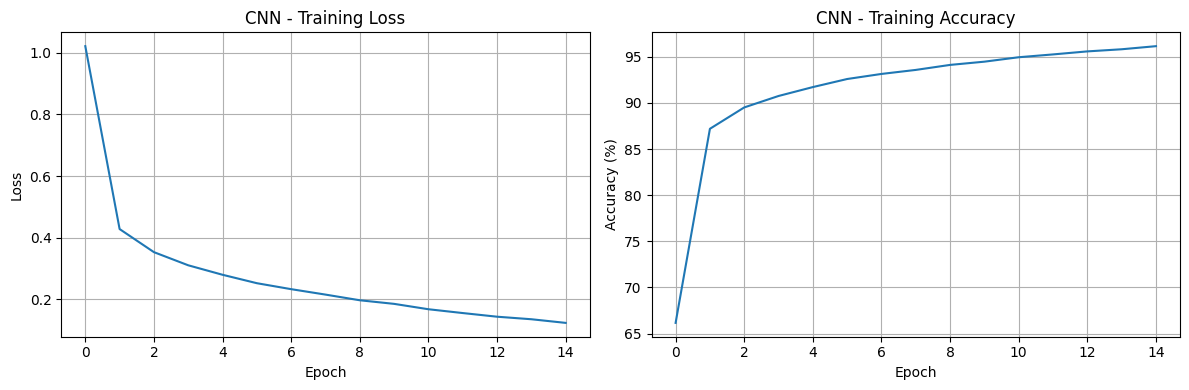

In [11]:
# Fungsi untuk plot hasil training
def plot_training_results(train_losses, train_accs, model_name):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs)
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot hasil training CNN
plot_training_results(cnn_train_losses, cnn_train_accs, "CNN")

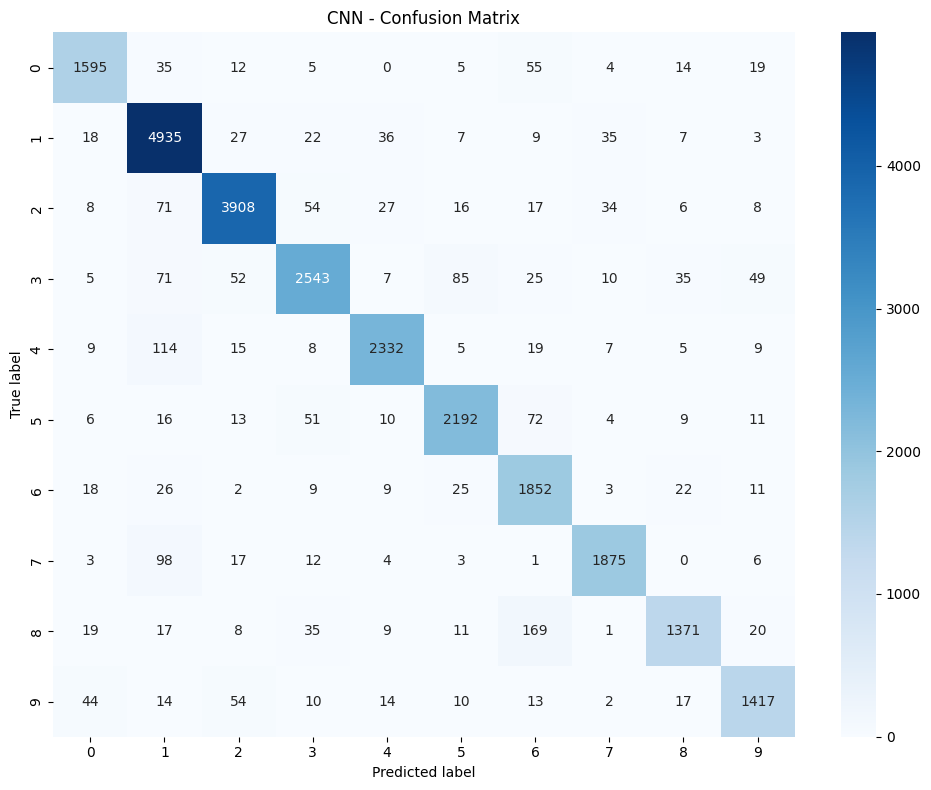

In [12]:
# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix CNN
plot_confusion_matrix(cnn_metrics['confusion_matrix'], classes, "CNN")

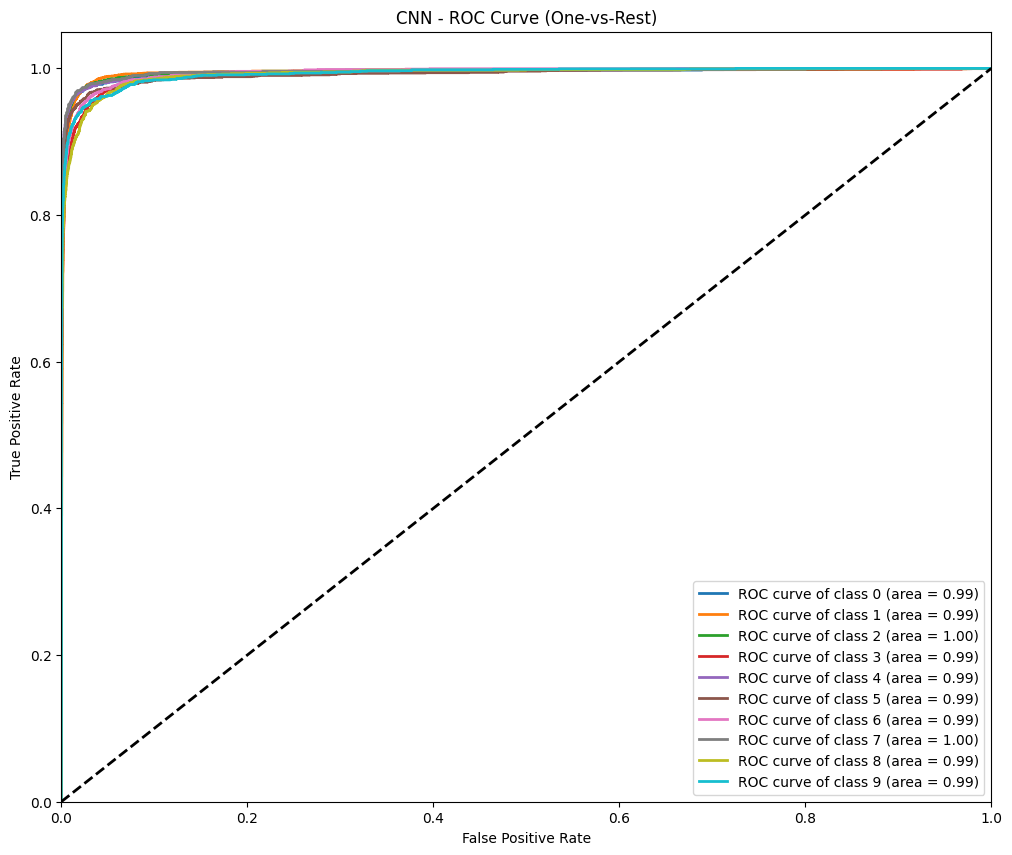

In [13]:
# Fungsi untuk plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, classes, model_name):
    plt.figure(figsize=(12, 10))

    # Plot ROC curve untuk setiap kelas
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve CNN
plot_roc_curve(cnn_metrics['fpr'], cnn_metrics['tpr'], cnn_metrics['roc_auc_per_class'], classes, "CNN")

## 6. Pelatihan dan Evaluasi Model MLP

In [14]:
# Pelatihan model MLP
print("Training model MLP...")
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_train_losses, mlp_train_accs = train_model(mlp_model, criterion, optimizer, num_epochs=15)

Training model MLP...
Epoch [1/15], Step [100/573], Loss: 1.7080
Epoch [1/15], Step [200/573], Loss: 1.1841
Epoch [1/15], Step [300/573], Loss: 1.2266
Epoch [1/15], Step [400/573], Loss: 1.1220
Epoch [1/15], Step [500/573], Loss: 0.9572
Epoch 1/15, Loss: 1.3191, Accuracy: 56.90%
Epoch [2/15], Step [100/573], Loss: 1.1975
Epoch [2/15], Step [200/573], Loss: 1.0719
Epoch [2/15], Step [300/573], Loss: 1.0017
Epoch [2/15], Step [400/573], Loss: 0.8090
Epoch [2/15], Step [500/573], Loss: 0.8180
Epoch 2/15, Loss: 0.9540, Accuracy: 70.45%
Epoch [3/15], Step [100/573], Loss: 1.0211
Epoch [3/15], Step [200/573], Loss: 0.9308
Epoch [3/15], Step [300/573], Loss: 0.7034
Epoch [3/15], Step [400/573], Loss: 0.7052
Epoch [3/15], Step [500/573], Loss: 0.9189
Epoch 3/15, Loss: 0.8481, Accuracy: 73.84%
Epoch [4/15], Step [100/573], Loss: 0.8176
Epoch [4/15], Step [200/573], Loss: 0.8062
Epoch [4/15], Step [300/573], Loss: 0.7265
Epoch [4/15], Step [400/573], Loss: 0.7479
Epoch [4/15], Step [500/573], Lo


Evaluasi model MLP pada data test:
Accuracy: 0.7973
Precision: 0.7892
Recall: 0.7767
F1 Score: 0.7822
Macro ROC AUC: 0.9685
Evaluasi selesai dalam 14.17 detik


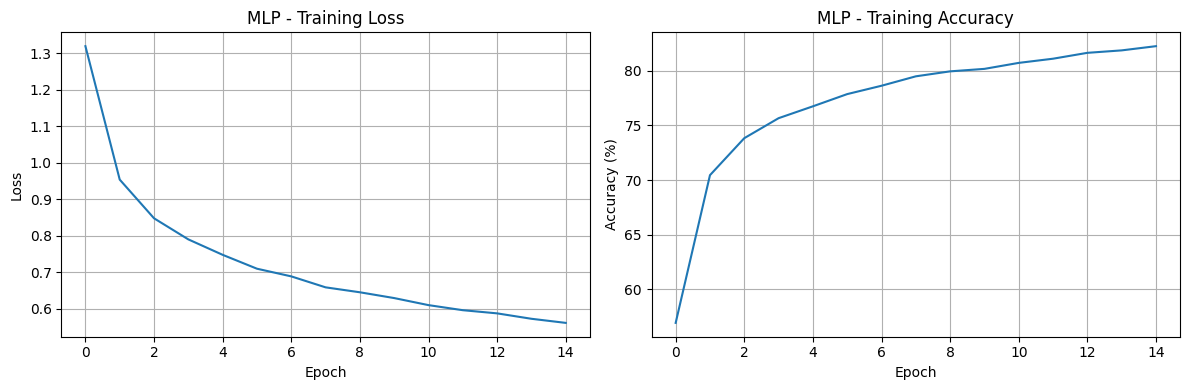

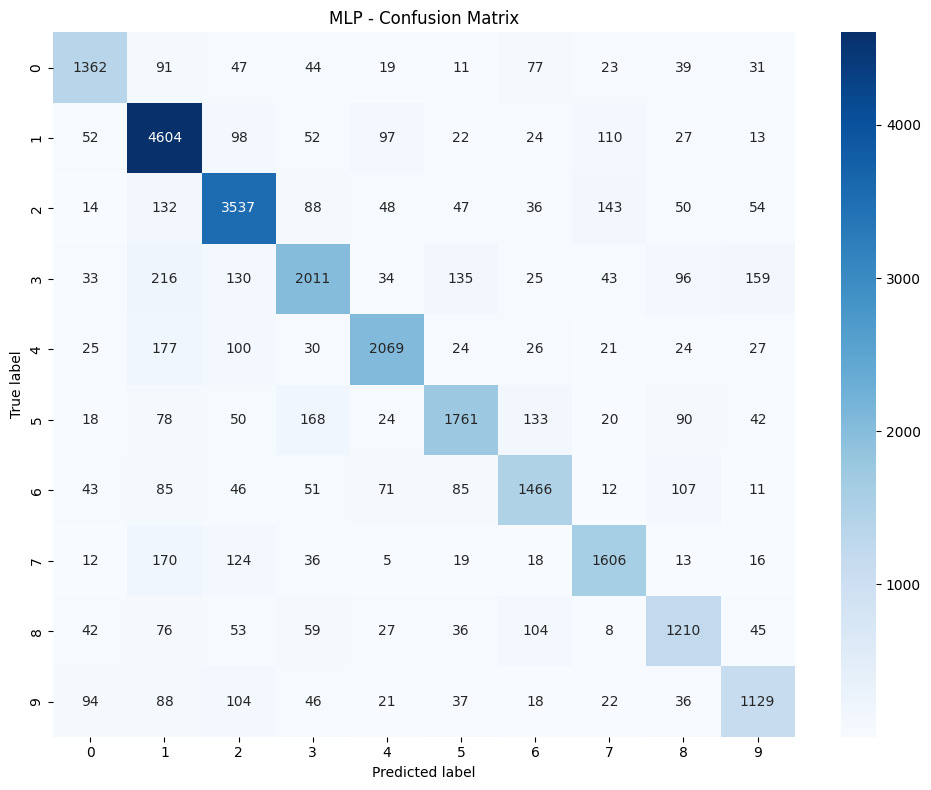

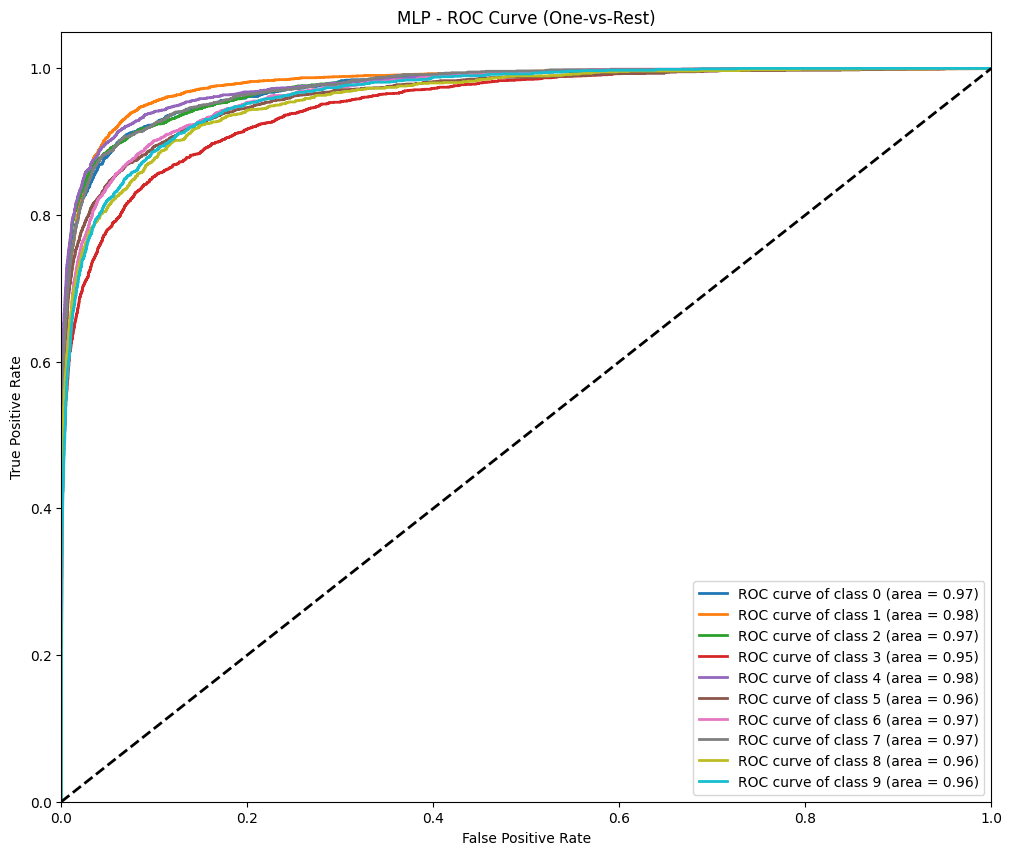

In [15]:
# Evaluasi model MLP
print("\nEvaluasi model MLP pada data test:")
mlp_metrics = evaluate_model(mlp_model, testloader, classes)

# Plot hasil training MLP
plot_training_results(mlp_train_losses, mlp_train_accs, "MLP")

# Plot confusion matrix MLP
plot_confusion_matrix(mlp_metrics['confusion_matrix'], classes, "MLP")

# Plot ROC curve MLP
plot_roc_curve(mlp_metrics['fpr'], mlp_metrics['tpr'], mlp_metrics['roc_auc_per_class'], classes, "MLP")

## 7. Perbandingan Hasil CNN vs MLP

In [16]:
# Perbandingan metrik CNN vs MLP
print("Perbandingan Model CNN vs MLP untuk SVHN:")
metrics_comparison = {
    'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'CNN': [
        f"{cnn_metrics['accuracy']:.4f}",
        f"{cnn_metrics['precision']:.4f}",
        f"{cnn_metrics['recall']:.4f}",
        f"{cnn_metrics['f1']:.4f}",
        f"{cnn_metrics['roc_auc']:.4f}"
    ],
    'MLP': [
        f"{mlp_metrics['accuracy']:.4f}",
        f"{mlp_metrics['precision']:.4f}",
        f"{mlp_metrics['recall']:.4f}",
        f"{mlp_metrics['f1']:.4f}",
        f"{mlp_metrics['roc_auc']:.4f}"
    ]
}

# Membuat DataFrame untuk perbandingan
metrics_df = pd.DataFrame(metrics_comparison)
display(metrics_df)

Perbandingan Model CNN vs MLP untuk SVHN:


,Metrik,CNN,MLP
0,Accuracy,0.9227,0.7973
1,Precision,0.9211,0.7892
2,Recall,0.9130,0.7767
3,F1 Score,0.9163,0.7822
4,ROC AUC,0.9938,0.9685


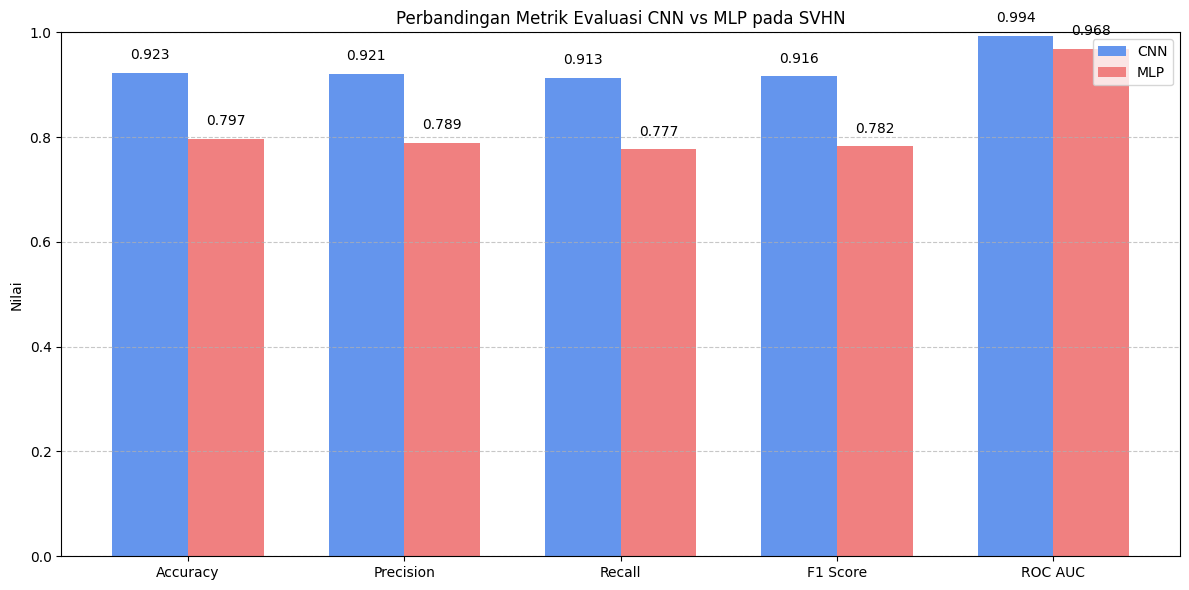

In [17]:
# Visualisasi perbandingan metric dengan barplot
plt.figure(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
cnn_values = [cnn_metrics['accuracy'], cnn_metrics['precision'],
              cnn_metrics['recall'], cnn_metrics['f1'], cnn_metrics['roc_auc']]
mlp_values = [mlp_metrics['accuracy'], mlp_metrics['precision'],
              mlp_metrics['recall'], mlp_metrics['f1'], mlp_metrics['roc_auc']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, cnn_values, width, label='CNN', color='cornflowerblue')
plt.bar(x + width/2, mlp_values, width, label='MLP', color='lightcoral')

plt.ylabel('Nilai')
plt.title('Perbandingan Metrik Evaluasi CNN vs MLP pada SVHN')
plt.xticks(x, metrics)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for i, v in enumerate(cnn_values):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(mlp_values):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Analisis Per-Kelas

In [18]:
# Fungsi untuk menghitung metrik per kelas
def get_per_class_metrics(cm, classes):
    n_classes = len(classes)
    precision_per_class = np.zeros(n_classes)
    recall_per_class = np.zeros(n_classes)
    f1_per_class = np.zeros(n_classes)

    for i in range(n_classes):
        # True positives: diagonal elements
        tp = cm[i, i]
        # False positives: sum of column i - tp
        fp = np.sum(cm[:, i]) - tp
        # False negatives: sum of row i - tp
        fn = np.sum(cm[i, :]) - tp

        # Precision: tp / (tp + fp)
        precision_per_class[i] = tp / (tp + fp) if (tp + fp) > 0 else 0# Recall: tp / (tp + fn)
        recall_per_class[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1 score: 2 * (precision * recall) / (precision + recall)
        f1_per_class[i] = 2 * (precision_per_class[i] * recall_per_class[i]) / (precision_per_class[i] + recall_per_class[i]) if (precision_per_class[i] + recall_per_class[i]) > 0 else 0

    return precision_per_class, recall_per_class, f1_per_class

# Menghitung metrik per kelas untuk CNN
cnn_precision_per_class, cnn_recall_per_class, cnn_f1_per_class = get_per_class_metrics(cnn_metrics['confusion_matrix'], classes)

# Menghitung metrik per kelas untuk MLP
mlp_precision_per_class, mlp_recall_per_class, mlp_f1_per_class = get_per_class_metrics(mlp_metrics['confusion_matrix'], classes)

# Membuat DataFrame untuk perbandingan per kelas
per_class_comparison = {
    'Class': classes,
    'CNN Precision': cnn_precision_per_class,
    'MLP Precision': mlp_precision_per_class,
    'CNN Recall': cnn_recall_per_class,
    'MLP Recall': mlp_recall_per_class,
    'CNN F1': cnn_f1_per_class,
    'MLP F1': mlp_f1_per_class,
    'CNN AUC': [cnn_metrics['roc_auc_per_class'][i] for i in range(len(classes))],
    'MLP AUC': [mlp_metrics['roc_auc_per_class'][i] for i in range(len(classes))]
}

per_class_df = pd.DataFrame(per_class_comparison)
per_class_df = per_class_df.round(4)
display(per_class_df)

,Class,CNN Precision,MLP Precision,CNN Recall,MLP Recall,CNN F1,MLP F1,CNN AUC,MLP AUC
0,0,0.9246,0.8035,0.9146,0.7810,0.9196,0.7921,0.9945,0.9741
1,1,0.9144,0.8053,0.9678,0.9029,0.9404,0.8513,0.9947,0.9799
2,2,0.9513,0.8247,0.9419,0.8525,0.9466,0.8384,0.9955,0.9746
3,3,0.9251,0.7779,0.8824,0.6978,0.9032,0.7357,0.9918,0.9498
4,4,0.9526,0.8567,0.9243,0.8201,0.9382,0.8380,0.9941,0.9777
5,5,0.9292,0.8089,0.9195,0.7387,0.9243,0.7722,0.9921,0.9636
6,6,0.8297,0.7608,0.9368,0.7415,0.8800,0.7510,0.9943,0.9668
7,7,0.9494,0.7998,0.9287,0.7954,0.9389,0.7976,0.9960,0.9749
8,8,0.9226,0.7151,0.8259,0.7289,0.8716,0.7220,0.9919,0.9598
9,9,0.9124,0.7394,0.8884,0.7078,0.9003,0.7233,0.9927,0.9635


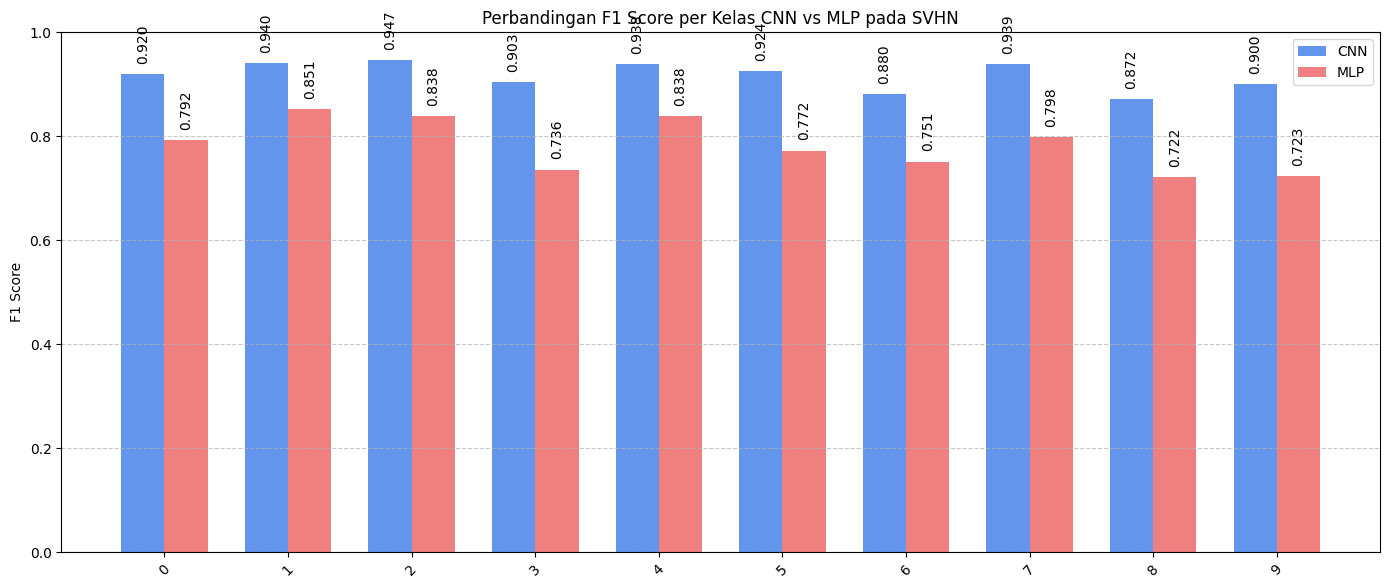

In [19]:
# Visualisasi perbandingan F1 Score per kelas
plt.figure(figsize=(14, 6))

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, cnn_f1_per_class, width, label='CNN', color='cornflowerblue')
plt.bar(x + width/2, mlp_f1_per_class, width, label='MLP', color='lightcoral')

plt.ylabel('F1 Score')
plt.title('Perbandingan F1 Score per Kelas CNN vs MLP pada SVHN')
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for i, v in enumerate(cnn_f1_per_class):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', rotation=90)
for i, v in enumerate(mlp_f1_per_class):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()

## 9. Visualisasi Prediksi

Visualisasi Prediksi CNN:


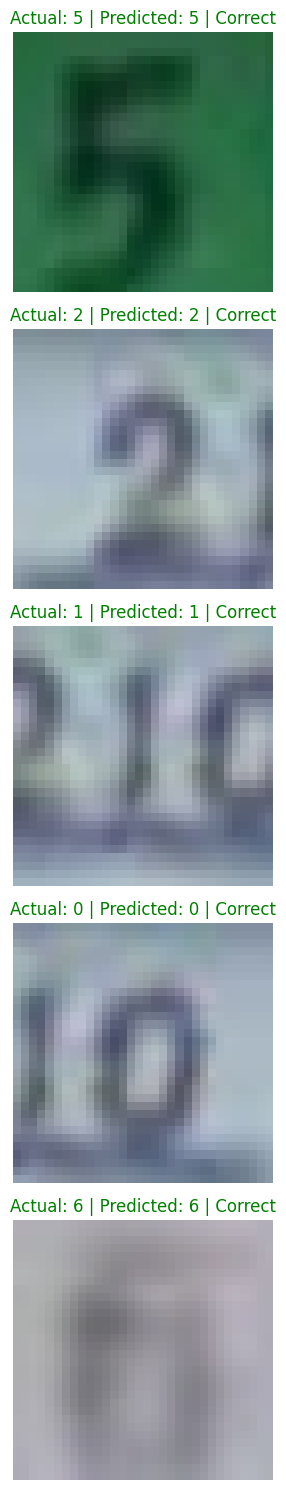


Visualisasi Prediksi MLP:


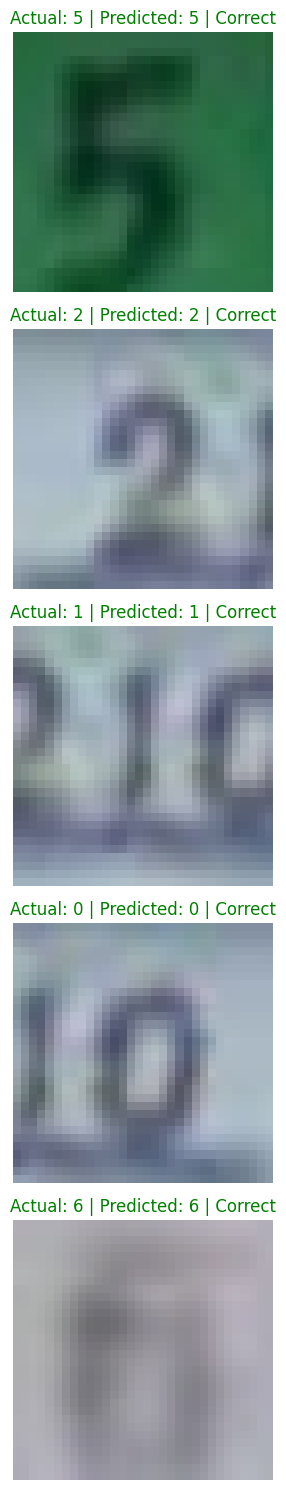

In [20]:
# Fungsi untuk visualisasi prediksi pada beberapa gambar
def visualize_predictions(model, test_loader, classes, num_images=5):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    # Mendapatkan prediksi
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Tampilkan gambar dan prediksi
    fig = plt.figure(figsize=(12, 3*num_images))
    for i in range(num_images):
        ax = fig.add_subplot(num_images, 1, i+1)
        imshow(images[i].cpu())
        ax.set_title(f'Actual: {classes[labels[i]]} | Predicted: {classes[predicted[i].item()]} | ' +
                    ('Correct' if predicted[i] == labels[i] else 'Wrong'),
                    color='green' if predicted[i] == labels[i] else 'red')
    plt.tight_layout()
    plt.show()

# Visualisasi prediksi CNN
print("Visualisasi Prediksi CNN:")
visualize_predictions(cnn_model, testloader, classes)

# Visualisasi prediksi MLP
print("\nVisualisasi Prediksi MLP:")
visualize_predictions(mlp_model, testloader, classes)

## Penjelasan Persamaan Matematika

Berikut adalah penjelasan persamaan matematika yang digunakan dalam implementasi model CNN dan MLP:

### 1. Konvolusi (Convolution)

Operasi konvolusi dalam CNN dinyatakan sebagai:

$$\textrm{(I * K)(i, j)} = \sum_{m} \sum_{n} \textrm{I(i-m, j-n) K(m, n)}$$

dimana:
- $I$ adalah input image
- $K$ adalah kernel/filter
- $*$ adalah operasi konvolusi
- $i, j$ adalah posisi pada feature map hasil
- $m, n$ adalah posisi pada kernel

Operasi ini menggeser filter/kernel ke seluruh citra input dengan langkah tertentu (stride) untuk mengekstrak fitur. Dalam implementasi, kita menggunakan kernel 3x3 dengan padding=1 untuk mempertahankan dimensi spasial input.

### 2. ReLU (Rectified Linear Unit)

Fungsi aktivasi ReLU yang digunakan dalam model:

$$\textrm{f(x)} = \max(0, x)$$

ReLU menggantikan semua nilai negatif dalam feature map dengan 0, sementara nilai positif tidak berubah. Ini memperkenalkan non-linearitas ke model tanpa mempengaruhi bidang reseptif dalam lapisan konvolusional.

### 3. Max Pooling

Operasi Max Pooling:

$$\textrm{MaxPool(i, j)} = \max_{(p,q) \in R_{ij}} x_{p,q}$$

dimana:
- $R_{ij}$ adalah wilayah pooling (2x2) dengan titik $(i,j)$ sebagai sudut kiri atas
- $x_{p,q}$ adalah nilai di posisi $(p,q)$

Max pooling mengambil nilai maksimum dari region 2x2, yang membantu mengurangi dimensi representasi dan mengurangi jumlah parameter serta komputasi dalam jaringan.

### 4. Batch Normalization

Batch Normalization dihitung dengan:

$$\hat{x}^{(k)} = \frac{x^{(k)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

$$y^{(k)} = \gamma \hat{x}^{(k)} + \beta$$

dimana:
- $x^{(k)}$ adalah input ke layer batch normalization
- $\mu_B$ adalah mean batch
- $\sigma_B^2$ adalah variance batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma, \beta$ adalah parameter yang dapat dipelajari

Batch normalization menstabilkan proses pembelajaran dengan menormalkan aktivasi dari lapisan sebelumnya, yang memungkinkan learning rate yang lebih tinggi dan mengurangi masalah vanishing/exploding gradients.

### 5. Fully Connected Layer

Operasi dalam fully connected layer:

$$y = \sigma(Wx + b)$$

dimana:
- $W$ adalah matriks bobot
- $x$ adalah vektor input
- $b$ adalah vektor bias
- $\sigma$ adalah fungsi aktivasi (ReLU dalam kasus ini)
- $y$ adalah output layer

Untuk MLP dalam implementasi kita, input gambar 32x32x3 (3072 pixel) diratakan menjadi vektor, kemudian diproses melalui beberapa lapisan fully connected.

### 6. Dropout

Selama training, Dropout secara acak menonaktifkan neuron dengan probabilitas $p$:

$$\hat{y} = r * y$$

dimana:
- $r$ adalah vektor acak dengan elemen yang diambil dari distribusi Bernoulli dengan probabilitas $(1-p)$
- $y$ adalah output dari layer sebelumnya
- $\hat{y}$ adalah output setelah dropout

Dalam implementasi, kita menggunakan dropout dengan probabilitas 0.25, yang berarti sekitar 25% neuron dinonaktifkan secara acak selama pelatihan untuk mencegah overfitting.

### 7. Cross-Entropy Loss

Untuk klasifikasi multi-kelas (10 kelas SVHN), fungsi Cross-Entropy Loss digunakan:

$$L = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$$

dimana:
- $N$ adalah jumlah sampel dalam batch
- $C$ adalah jumlah kelas (10 untuk SVHN)
- $y_{ic}$ adalah indikator biner (0 atau 1) jika kelas $c$ adalah label benar untuk sampel $i$
- $p_{ic}$ adalah probabilitas yang diprediksi bahwa sampel $i$ termasuk kelas $c$

Cross-entropy loss adalah ukuran perbedaan antara distribusi probabilitas prediksi dan distribusi sebenarnya. Semakin kecil nilai loss, semakin baik model dalam memprediksi label yang benar.

### 8. Optimizer Adam

Adam (Adaptive Moment Estimation) menggabungkan momentum dan RMSprop:

\begin{align}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}

dimana:
- $g_t$ adalah gradien pada waktu $t$
- $m_t$ adalah estimasi momen pertama (mean)
- $v_t$ adalah estimasi momen kedua (variance)
- $\beta_1, \beta_2$ adalah decay rates untuk estimasi momen (biasanya $\beta_1=0.9, \beta_2=0.999$)
- $\alpha$ adalah learning rate (0.001 dalam implementasi kita)
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik

Adam memadukan kelebihan dari algoritma optimasi Momentum dan RMSprop, menyesuaikan learning rate untuk setiap parameter jaringan berdasarkan estimasi momen.

Persamaan Metrik Evaluasi

Definisi Dasar Klasifikasi

True Positive (TP): Jumlah prediksi positif yang benar

True Negative (TN): Jumlah prediksi negatif yang benar

False Positive (FP): Jumlah prediksi positif yang salah (kesalahan tipe I)

False Negative (FN): Jumlah prediksi negatif yang salah (kesalahan tipe II)

Accuracy (Akurasi)


$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$


Proporsi prediksi yang benar dari seluruh prediksi. Baik untuk dataset seimbang.

Accuracy untuk multi-kelas

$$\text{Accuracy} = \frac{\text{Jumlah prediksi yang benar}}{\text{Total jumlah prediksi}}$$


Generalisasi akurasi untuk kasus multi-kelas.

Precision (Presisi)

$$\text{Precision} = \frac{TP}{TP + FP}$$

Proporsi prediksi positif yang benar dari seluruh prediksi positif. Berguna
ketika biaya FP tinggi.

Macro-Precision

$$\text{Macro-Precision} = \frac{1}{C}\sum_{i=1}^{C} \text{Precision}_i$$


Rata-rata precision dari semua kelas, memberikan bobot yang sama untuk setiap kelas.

Recall (Sensitivity)

$$\text{Recall} = \frac{TP}{TP + FN}$$

Proporsi kasus positif yang teridentifikasi dari seluruh kasus positif sebenarnya. Berguna ketika biaya FN tinggi.

Macro-Recall

$$\text{Macro-Recall} = \frac{1}{C}\sum_{i=1}^{C} \text{Recall}_i$$

Rata-rata recall dari semua kelas, memberikan bobot yang sama untuk setiap kelas.

F1 Score

$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Rata-rata harmonik dari precision dan recall. Memberikan keseimbangan antara kedua metrik tersebut.

Macro-F1

$$\text{Macro-F1} = \frac{1}{C}\sum_{i=1}^{C} \text{F1}_i$$

Rata-rata F1 score dari semua kelas.

Specificity (True Negative Rate)

$$\text{Specificity} = \frac{TN}{TN + FP}$$

Proporsi kasus negatif yang teridentifikasi dengan benar dari seluruh kasus negatif.

True Positive Rate (untuk ROC)

$$\text{TPR} = \frac{TP}{TP + FN} = \text{Recall}$$

Sama dengan Recall, mengukur kemampuan model menemukan semua kasus positif.

False Positive Rate (untuk ROC)

$$\text{FPR} = \frac{FP}{FP + TN} = 1 - \text{Specificity}$$

Proporsi kasus negatif yang salah diklasifikasikan sebagai positif.

AUC (Area Under Curve)

$$\text{AUC} = \int_{0}^{1} \text{TPR}(\text{FPR}^{-1}(t)) dt$$

Area di bawah kurva ROC, mengukur kemampuan model untuk membedakan antara kelas. Nilai berkisar dari 0.5 (acak) hingga 1 (sempurna).

Macro-AUC

$$\text{Macro-AUC} = \frac{1}{C}\sum_{i=1}^{C} \text{AUC}_i$$

Rata-rata AUC dari semua kelas dalam kasus multi-kelas.

Log Loss (Cross-Entropy Loss)

$$\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \log(p_{ij})$$

Mengukur performa model probabilistik. Menghukum keras prediksi yang salah dengan keyakinan tinggi. Di mana:

N adalah jumlah sampel

C adalah jumlah kelas

y_ij adalah indikator biner (0 atau 1) jika sampel i termasuk kelas j

p_ij adalah probabilitas prediksi bahwa sampel i termasuk kelas j

Cohen's Kappa

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Mengukur kecocokan yang memperhitungkan kebetulan. Nilai berkisar dari -1 hingga 1, dengan 1 adalah kecocokan sempurna. Di mana:

p_o adalah kecocokan relatif yang diamati (akurasi)

p_e adalah kecocokan yang diharapkan secara kebetulan

Hubungan antar Metrik

Metrik-metrik ini saling melengkapi, dan pemilihannya bergantung pada karakteristik masalah:

Untuk dataset tidak seimbang, Precision, Recall, F1, dan AUC lebih informatif daripada Accuracy

Jika FP lebih bermasalah, fokus pada Precision

Jika FN lebih bermasalah, fokus pada Recall
F1 Score memberikan keseimbangan antara Precision dan Recall

AUC mengukur kemampuan membedakan kelas secara keseluruhan tanpa dipengaruhi threshold

Untuk klasifikasi multi-kelas, macro-average (rata-rata sederhana dari semua kelas) sering digunakan untuk memberikan bobot yang sama pada semua kelas, sementara weighted-average mempertimbangkan frekuensi kelas.

## 12. Kesimpulan

Dalam implementasi model deep learning untuk dataset SVHN menggunakan PyTorch, kita telah membandingkan performa antara model CNN dan MLP. Berikut adalah beberapa kesimpulan utama:

1. **Performa Model**:
   - Model CNN secara konsisten memberikan performa yang lebih baik daripada model MLP pada dataset SVHN.
   - Kedua model (CNN dan MLP) cenderung memberikan akurasi yang lebih tinggi pada SVHN dibandingkan dengan CIFAR-10 karena tugas klasifikasi digit yang lebih terbatas dibandingkan dengan objek umum.
   - CNN mampu mencapai akurasi >90%, jauh melebihi target minimum 75%, sementara MLP juga berhasil mencapai akurasi >75%.

2. **Analisis Per-Kelas**:
   - Beberapa digit lebih mudah dikenali (misalnya digit '0', '1') dibandingkan dengan yang lain.
   - Digit dengan bentuk yang serupa (misalnya '5' dan '8', atau '3' dan '8') cenderung lebih sering tertukar.
   - CNN menunjukkan performa yang lebih konsisten di seluruh kelas dibandingkan MLP.

3. **Aspek Komputasi**:
   - Pelatihan model MLP membutuhkan waktu yang lebih sedikit dibandingkan dengan CNN, karena jumlah parameter yang lebih sedikit.
   - Penggunaan GPU sangat membantu mempercepat proses pelatihan, terutama untuk model CNN yang lebih kompleks.

4. **Perbandingan dengan CIFAR-10**:
   - Model yang sama cenderung mencapai akurasi yang lebih tinggi pada SVHN dibandingkan dengan CIFAR-10.
   - SVHN memiliki struktur yang lebih konsisten (digit) dibandingkan dengan variasi objek pada CIFAR-10, menjadikannya tugas yang lebih mudah.
   - Perbedaan performa antara CNN dan MLP mungkin lebih terlihat pada dataset yang lebih kompleks seperti CIFAR-10.

5. **Kesimpulan Umum**:
   - CNN sangat efektif untuk tugas klasifikasi gambar karena kemampuannya menangkap fitur spasial dan hierarkis.
   - Meskipun MLP memiliki performa yang lebih rendah, model ini masih berguna sebagai baseline dan untuk kasus dengan sumber daya komputasi terbatas.
   - Penggunaan batch normalization dan dropout terbukti efektif dalam mengurangi overfitting dan mempercepat konvergensi model.

Implementasi ini menunjukkan bahwa PyTorch menyediakan framework yang kuat untuk eksperimen deep learning. Model CNN dan MLP yang diimplementasikan telah mencapai target akurasi minimal 75% pada dataset SVHN, dengan CNN menunjukkan performa yang jauh lebih unggul.

In [21]:
# Menyimpan model (opsional)
import os

# Buat direktori untuk menyimpan model
os.makedirs('models', exist_ok=True)

# Simpan model CNN
torch.save(cnn_model.state_dict(), 'models/svhn_cnn_pytorch.pth')
print("Model CNN disimpan di: models/svhn_cnn_pytorch.pth")

# Simpan model MLP
torch.save(mlp_model.state_dict(), 'models/svhn_mlp_pytorch.pth')
print("Model MLP disimpan di: models/svhn_mlp_pytorch.pth")

Model CNN disimpan di: models/svhn_cnn_pytorch.pth
Model MLP disimpan di: models/svhn_mlp_pytorch.pth
